### Name: Binben Wang
### NSID: biw123

In [2]:
import os
import folium
import numpy as np
import pandas as pd
import pyproj as pj
import math
from folium.plugins import HeatMap
from collections import Counter
import matplotlib
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
import scipy.stats as stats
import pylab as pl
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# STEP 1: Preparation

In [2]:
# gps.csv contains five features: user_id, record_time, latitude, longitude, accu
gps_df = pd.read_csv("../A1/gps.csv")
# battery.csv contains two features: user_id, record_time
battery_df = pd.read_csv("../A1/battery.csv")

In [14]:
# latitude and longitude of saskatoon center
lat_center_saskatoon = (52.058367 + 52.214608) / 2
lon_center_saskatoon = (-106.7649138128 - 106.52225318) / 2

In [4]:
# calculate number of total possible battery records per particiants
battery_df.record_time = battery_df.record_time.astype('datetime64')
time_interval = battery_df.record_time.max() - battery_df.record_time.min()
num_total_possible_records = np.ceil(time_interval.total_seconds() / 300)

In [5]:
# calculate the number of all battery records per user.
battery_counts_df = battery_df.groupby(['user_id']).size().reset_index(name='counts')
battery_counts_df.describe()

,user_id,counts
count,108.000000,108.000000
mean,1084.518519,3276.287037
std,274.204286,2718.917432
min,264.000000,1.000000
25%,939.750000,646.750000
50%,1077.500000,2233.000000
75%,1315.250000,6155.750000
max,1364.000000,7655.000000


In [6]:
# filter battery dataframe in 50% threshold
fifty_user_df = battery_counts_df[battery_counts_df.counts >= num_total_possible_records * 0.5]
fifty_user_df.count()

user_id    43
counts     43
dtype: int64

In [9]:
analysis_gps_df = gps_df[(gps_df.lat <= 52.214608) & (gps_df.lat >= 52.058367) & (gps_df.lon <= -106.52225318) & (gps_df.lon >= -106.7649138128) & (gps_df.accu <= 100) & (gps_df.user_id.isin(fifty_user_df.user_id.values.tolist()))]

In [11]:
# save the gps records that we will analyze into csv file
analysis_gps_df.to_csv('analysis_gps.csv', index=False)

In [3]:
analysis_gps_df = pd.read_csv("analysis_gps.csv")

In [4]:
# convert the datatype of record_time from object to datatime64
analysis_gps_df.record_time = analysis_gps_df.record_time.astype('datetime64')
# calculate the minimum timestamp of all records
min_timestamp = analysis_gps_df.record_time.min()

In [5]:
# convert record_time to relative_time by duty cycle
analysis_gps_df.loc[:, 'relative_time'] = np.floor((analysis_gps_df.record_time - min_timestamp).dt.total_seconds() / 300).astype('int')
# We don't need the 'accu' column in further analysis
analysis_gps_df = analysis_gps_df.drop(columns=['accu'])

In [6]:
# group the dataframe by user_id, and relative_time, then calculate the average latitude and longitude coordinates
analysis_gps_df_aggregated = analysis_gps_df.groupby(['user_id', 'relative_time'], as_index=False).mean()

In [7]:
# transfer latitude and longitude coordinates to UTM coordinates
p1 = pj.Proj(init='epsg:32613')
x, y = p1(analysis_gps_df_aggregated.lon.values.tolist(), analysis_gps_df_aggregated.lat.values.tolist())
analysis_gps_df_aggregated.loc[:, 'x'] = x
analysis_gps_df_aggregated.loc[:, 'y'] = y

In [8]:
# drop lat and lon columns, we don't need that
analysis_gps_df_aggregated = analysis_gps_df_aggregated.drop(columns=['lat', 'lon'])

In [9]:
# save gps records in UTM coordinates into csv file
analysis_gps_df_aggregated.to_csv('aggregated_x_y_location.csv', index=False)

In [10]:
# calculate the start and end coordinates in UTM for the greater Saskatoon area
start_x, start_y = p1(-106.7649138128, 52.058367)
end_x, end_y = p1(-106.52225318, 52.214608)

In [11]:
# convert UTM coordinates into grid coordinates
def which_grid(x, y, start_x, start_y, step):
    which_grid_x = np.floor((x - start_x) / step)
    which_grid_y = np.floor((y - start_y) / step)
    
    # in case UTM coordinates in the boundary of the greater Saskatoon area
    # there are some -1 value appearing
    # set all -1 to 0
    which_grid_x[which_grid_x < 0] = 0
    which_grid_y[which_grid_y < 0] = 0
    
    return(which_grid_x, which_grid_y)

# STEP 2: Trip Definition

For N-times definition, I include firt N repeated grids into the following trip but include only 1 grid when the trip ends due to more than or equal to N repeated grids.

For example, given grid sequence: AAAABBCDDDDDEFGG

AAABBCD is a trip. And DDDEFGG is another trip.

In [12]:
def operationalize(file_path, lat_center_saskatoon, lon_center_saskatoon, start_x, end_x, start_y, end_y, step, N):
    # load the data we want to operationalize
    df = pd.read_csv(file_path)
    
    # convert UTM coordinates into grid coordinates
    df.loc[:, 'grid_x'], df.loc[:, 'grid_y'] = which_grid(df.x.values, df.y.values, start_x, start_y, step)
    df = df.drop(columns=['x', 'y'])
    
    #convert datatype from float64 to int
    df.grid_x = df.grid_x.astype('int')
    df.grid_y = df.grid_y.astype('int')
    
    # sort dataframe
    df = df.sort_values(by=['user_id', 'relative_time'])
    
    # whether an observation is in a trip
    not_in_trip = ((df.grid_x == shift(df.grid_x, -1, cval=0)) & (df.grid_y == shift(df.grid_y, -1, cval=0)))
    for i in range(1, N):
        not_in_trip = not_in_trip & ((shift(df.grid_x, -1 * i, cval=0) == shift(df.grid_x, -1 * (i + 1), cval=0)) & (shift(df.grid_y, -1 * i, cval=0) == shift(df.grid_y, -1 * (i + 1), cval=0)))
    df.loc[:, 'not_in_trip'] = not_in_trip
    df.not_in_trip = df.not_in_trip.astype('int')

    # cumsum of not_in_trip
    df.loc[:, 'trip'] = df.not_in_trip.cumsum()
    
    # calculate trip numbers
    
    
    # calculate trip duration and trip numbers
    temp = df
    durations_per_participant = temp.groupby(['user_id', 'trip']).size().reset_index(name='duration')
    # filter all durations less than or equal N, they are not trips
    durations_per_participant = durations_per_participant[durations_per_participant.duration > N]
    num_of_trips_per_participant = durations_per_participant.groupby(['user_id']).size().reset_index(name='num_of_trip')
    tn = num_of_trips_per_participant[['user_id', 'num_of_trip']].values
    durations = temp.groupby(['trip']).size().reset_index(name='duration')
    counts_of_durations = durations.groupby(['duration']).size().reset_index(name='num_of_duration')
    td = counts_of_durations[['duration', 'num_of_duration']].values
    
    # calculate trip duration
    temp = df
    temp.loc[:, 'change_grid'] = ((temp.grid_x != shift(temp.grid_x, -1, cval=0)) | (temp.grid_y != shift(temp.grid_y, -1, cval=0)))
    temp.change_grid = temp.change_grid.astype('int')
    lengths = temp.groupby(['trip']).change_grid.sum().reset_index(name='length')
    counts_of_lengths = lengths.groupby(['length']).size().reset_index(name = 'num_of_length')
    tl = counts_of_lengths[['length', 'num_of_length']].values
    
    # Convert grid coordinates back to lat and lon coordinates
    temp_x = (df.grid_x + 0.5) * step + start_x
    temp_y = (df.grid_y + 0.5) * step + start_y
    temp_x[temp_x > end_x] = end_x
    temp_y[temp_y > end_y] = end_y
    df.loc[:, 'center_lon'], df.loc[:, 'center_lat'] = p1(temp_x.tolist(), temp_y.tolist(), inverse=True)
    
    # render the heatmap including only trips
    m1 = folium.Map([lat_center_saskatoon, lon_center_saskatoon], tiles='stamentoner', zoom_start=6)
    HeatMap(df.loc[df.not_in_trip == 0, ['center_lat', 'center_lon']].values.tolist()).add_to(m1)
    filename = str(N) + "_times_trip_only_heatmap.html"
    
    # render the heatmap including only non-trips
    m2 = folium.Map([lat_center_saskatoon, lon_center_saskatoon], tiles='stamentoner', zoom_start=6)
    HeatMap(df.loc[df.not_in_trip == 1, ['center_lat', 'center_lon']].values.tolist()).add_to(m2)
    filename = str(N) + "_times_non_trip_only_heatmap.html"
    
    return (td, tl, tn, m1, m2)

# STEP 3: Presentation

In [15]:
td_1, tl_1, tn_1, m_trip_1, m_nontrip_1 = operationalize('aggregated_x_y_location.csv', lat_center_saskatoon, lon_center_saskatoon, start_x, end_x, start_y, end_y, 100, 1)

In [16]:
# Pleace uncomment all heatmap if you want to see it. I commented it because it is too large to upload.
# m_trip_1

In [17]:
# m_nontrip_1

In [18]:
td_3, tl_3, tn_3, m_trip_3, m_nontrip_3 = operationalize('aggregated_x_y_location.csv', lat_center_saskatoon, lon_center_saskatoon, start_x, end_x, start_y, end_y, 100, 3)

In [19]:
# m_trip_3

In [20]:
# m_nontrip_3

In [21]:
td_5, tl_5, tn_5, m_trip_5, m_nontrip_5 = operationalize('aggregated_x_y_location.csv', lat_center_saskatoon, lon_center_saskatoon, start_x, end_x, start_y, end_y, 100, 5)

In [22]:
# m_trip_5

In [23]:
# m_nontrip_5

### Choice of Distribution for Trip Duration
##### Try 1: power law

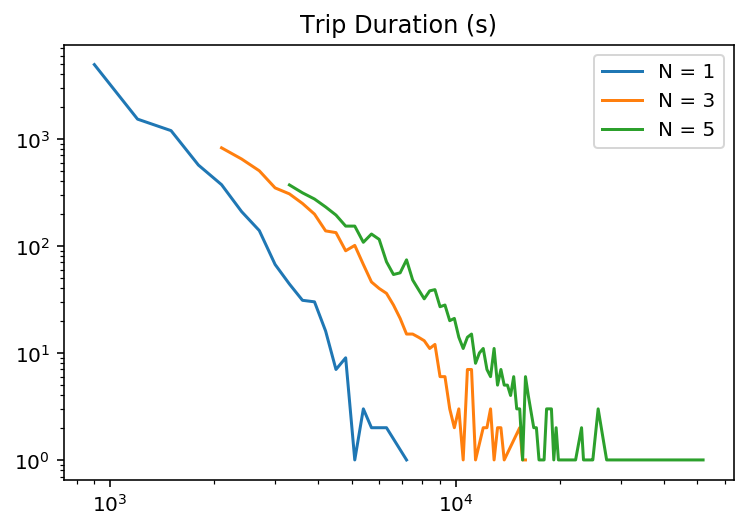

In [376]:
# No trip duration can be less than N + 1 when using N-times definition
plt.loglog(td_1[2:,0] * 5 * 60, td_1[2:,1])
plt.loglog(td_3[4:,0] * 5 * 60, td_3[4:,1])
plt.loglog(td_5[6:,0] * 5 * 60, td_5[6:,1])
plt.legend(["N = 1", "N = 3", "N = 5"])
plt.title("Trip Duration (s)")
plt.show()

##### Try 2: exponential

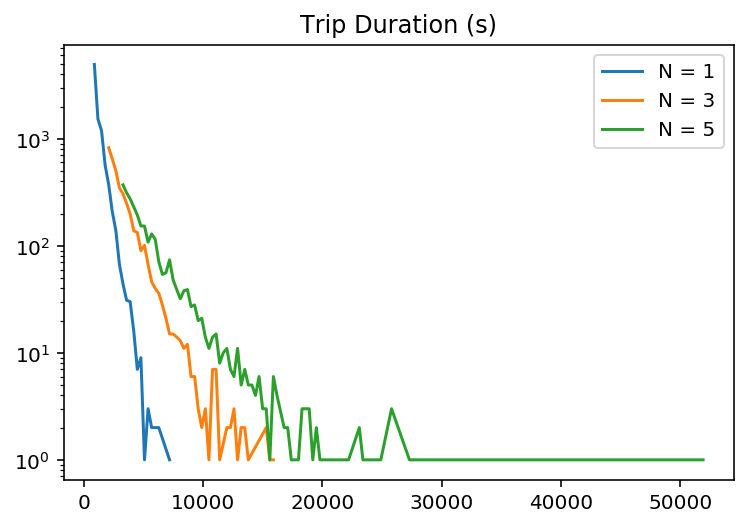

In [377]:
plt.semilogy(td_1[2:,0] * 5 * 60, td_1[2:,1])
plt.semilogy(td_3[4:,0] * 5 * 60, td_3[4:,1])
plt.semilogy(td_5[6:,0] * 5 * 60, td_5[6:,1])
plt.legend(["N = 1", "N = 3", "N = 5"])
plt.title("Trip Duration (s)")
plt.show()

As we can see, both power law distribtions and expoential distribtions fit trip duration pretty well. One drawback of expoential distribution in this case is that the slope of lines in the above figure is too large. When we try to fit this distribution, it may cause large errors. And gaussian distributions are bell curves. They definitely won't fit trip durations. 

### Choice of Distribution for Trip Length
##### Try 1: power law

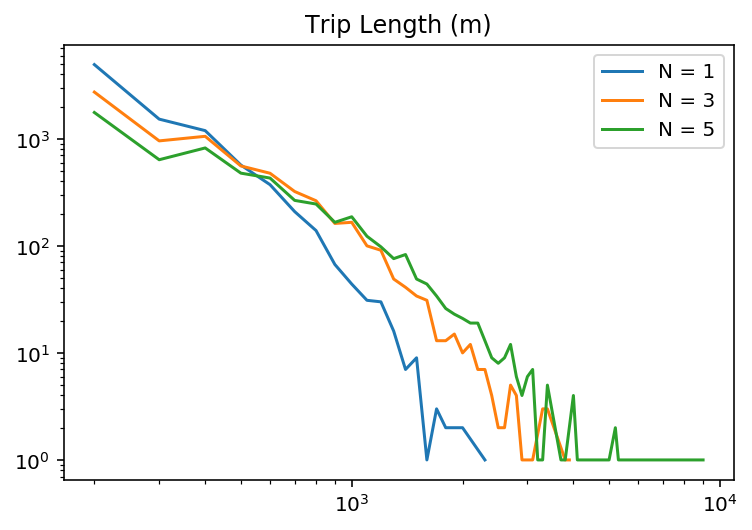

In [378]:
# No trip length can be less than 2
plt.loglog(tl_1[2:,0] * 100, tl_1[2:,1])
plt.loglog(tl_3[2:,0] * 100, tl_3[2:,1])
plt.loglog(tl_5[2:,0] * 100, tl_5[2:,1])
plt.legend(["N = 1", "N = 3", "N = 5"])
plt.title("Trip Length (m)")
plt.show()

##### Try 2: exponential

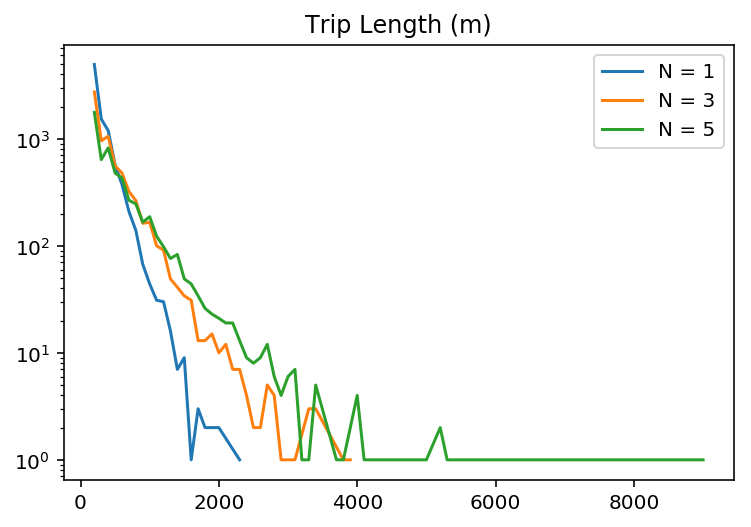

In [379]:
# No trip length can be less than 2
plt.semilogy(tl_1[2:,0] * 100, tl_1[2:,1])
plt.semilogy(tl_3[2:,0] * 100, tl_3[2:,1])
plt.semilogy(tl_5[2:,0] * 100, tl_5[2:,1])
plt.legend(["N = 1", "N = 3", "N = 5"])
plt.title("Trip Length (m)")
plt.show()

Reasons are the same as reasons for trip durations.

### Choice of Distribution for Trip Number

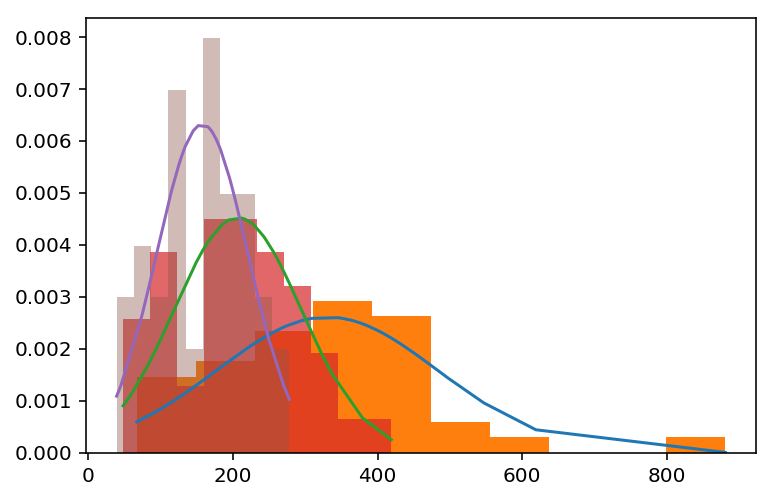

In [380]:
h_1 = sorted(tn_1[:, 1])
fit = stats.norm.pdf(h_1, np.mean(h_1), np.std(h_1)) 
pl.plot(h_1,fit)
pl.hist(h_1,density=True, alpha=1)

h_3 = sorted(tn_3[:, 1])
fit = stats.norm.pdf(h_3, np.mean(h_3), np.std(h_3))  
pl.plot(h_3,fit)
pl.hist(h_3,density=True, alpha=0.7) 

h_5 = sorted(tn_5[:, 1])
fit = stats.norm.pdf(h_5, np.mean(h_5), np.std(h_5))  
pl.plot(h_5,fit)
pl.hist(h_5,density=True, alpha=0.4)

pl.show() 

From all three histogram graphs, we know that the probability (counts) of a trip number first increases then decreases as trip numbers increase. So the distribution of trip numbers is a bell curve, which is the shape of  gaussian distributions. Whereas the probability of exponential distributions and power law distribtions decreases all the time as $x$ increases. So these two distributions will not fit trip numbers.

# STEP 4: Interpretation
#### 4.1 What is the impact of changing N on the distribution of trip number, length and duration? What trips are being captured and which are being ignored? Given an example of a research question where the differences would be important, and an example of a question where they would be unimportant.
* When increasing $N$, distributions of trip number, trip length and trip duration keep the same. However, the distribtion of trip number has larger mean and larger standard deviation, which is shown as more flat bell curves. Distributions of trip length and trip duration decrease slower as N increases.
* Trips from one grid to another grid will be captured depending on $N$. Trips within a single grid will be ignored
* When comparing trip behaviors of people from different areas, this will be important.
* When studying trip behaviors of certain group of people from same area, this would be unimportant.

#### 4.2 What distinguishing features did you see in the heatmaps? Where there points included in either map (trip, not trip) at any N that seemed out of place? How would you change the operationalization to eliminate these points?
* As $N$ becoming larger, there are more data on trip heatmaps and less data on non-trip heatmaps. Because more and more GPS will be categorized as trips. And we also can see that people are often in the building when they are in non-trips and are often in the road when they are in trips.
* Many GPS records in shopping malls are categorized as non-trips. I think this is uncorrect.
* I can decrease the time period used to down-sampling, we are more likely to see people moving in shopping malls when the time period is small.

#### 4.3 Using the DADeP as headings, describe the entire process of this assignment as a series of algorithms. Assuming you have access to a function probability_of_location(location) describe the process using the dynamic location formalism described in class.
* Filter: first of all, I remove all unvalid data including GPS data with low accuracy, GPS data out of Saskatoon, and participants without enough records.
* Stratify: Then I separate GPS data into two types, one is in trips and the another is in non-trips.
* Aggregate: I aggregate data by duty cycles and grids.
* Model: I use different distributions to fit trip number, trip length, and trip duration.